In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import time
import math

In this file, I create dataframes of recovery data for each of my teammmates. In other files I use these dataframes to analyze the effects of physiological variables collected from the WHOOP Strap on race performance and weekly bike efforts.

First, I take the file sleeps.csv, drop the two subjects whose data I won't use (myself and one person who only used WHOOP for a couple of days), and remove all the sleeps recorded that were naps. I saved this into a csv file. 

In [4]:
#sleeps_temp = pd.read_csv('sleeps.csv')
#sleeps_temp = sleeps_temp[sleeps_temp.user_id!=2509]
#sleeps_temp = sleeps_temp[sleeps_temp.user_id!=2461]
#sleeps_temp = sleeps_temp[sleeps_temp.is_nap=='f'].reset_index()
#sleeps_temp.to_csv('sleeps_temp.csv')

Then I manually add in the 'missing days' in the csv file (meaning nights that were missing because of either the subject losing his WHOOP Strap or some system error), then upload it back into the notebook. As seen below, the 'date_md' variable contains thte date of the eend of the sleep. However, there are nights (such as ID 828 on 10/11/2015), where sleep data was not recorded, due to either a malfunction in the WHOOP strap or, most likely, the subject not wearing the WHOOP strap that night. With the missing days added in (with null values for other variables), each subject has one row of sleep data per day from 9/15/2015 to 11/23/2015.

With a small sample size such as this, it was easier and more efficient for me to add in the 'missing days' by hand. I commented out the code above so I could run the whole file without needing to fill in the missing days again. 

Note: 'date_md' is simply the date in months/days

In [5]:
#manually added in missing days in Excel
sleeps = pd.read_csv('sleeps_temp.csv')
sleeps.head(30)

,user_id,start,end,date_md,score,time_in_bed,latency,disturbances,wake_duration,light_sleep_duration,slow_wave_sleep_duration,rem_sleep_duration,cycles_count,debt_post,is_nap,recovery_score,resting_heart_rate,hrv_rmssd
0,828,9/15/2015 2:42,9/15/2015 12:09,9/15,82,34020000,2100132,27,6870000,22230000,3600000,1320000,2,4266209.55,f,63,49,0.064647
1,828,9/16/2015 2:03,9/16/2015 12:06,9/16,87,36180000,2790134,25,6630000,22860000,3210000,3480000,3,2436815.25,f,74,45,0.075670
2,828,9/17/2015 0:36,9/17/2015 12:15,9/17,97,41940000,7800470,24,10410000,25680000,3240000,2580000,4,513169.69,f,68,44,0.036925
3,828,9/18/2015 2:38,9/18/2015 12:24,9/18,94,35150127,1410042,32,3960000,24810000,2160000,4230000,7,1425316.75,f,90,53,0.098787
4,828,9/19/2015 1:44,9/19/2015 11:30,9/19,0,0,0,NaN,0,0,0,0,NaN,NaN,f,NaN,NaN,NaN
5,828,9/20/2015 3:38,9/20/2015 11:44,9/20,70,29156349,1560075,18,4260000,18090000,2910000,3900000,6,7668000.00,f,42,43,0.050816
6,828,9/21/2015 2:30,9/21/2015 12:18,9/21,74,35273083,1525941,23,6270000,16020000,4620000,8370000,6,4792906.02,f,50,45,0.058456
7,828,9/22/2015 2:16,9/22/2015 12:37,9/22,93,37294761,1050923,31,4860000,24000000,3870000,4560000,7,1012272.72,f,69,43,0.063264
8,828,9/23/2015 2:44,9/23/2015 12:20,9/23,87,34522859,870915,23,3630000,22560000,2940000,5400000,10,2610197.56,f,76,47,0.081390
9,828,9/24/2015 3:03,9/24/2015 12:34,9/24,89,34284759,1140930,14,3360000,22140000,3480000,5310000,10,2307830.92,f,74,46,0.076798


I created this list of unique user IDs that I use later

In [6]:
#a list of the unique users in the sleep dataset
users = list(set(sleeps.user_id.values))

This function takes the end of a user's sleep and converts the date and time into epoch time in milliseconds, creating a new variable. I then apply the function to the sleep dataframe. This allows for me the exact date in epoch time that a subject ended sleeping that morning. 

In [7]:
def epoch_end_convert(df):
    '''
    takes dataframe and converts date column to epoch milliseconds
    inputs:
        df = dataframe name
        
    returns:
        a dataframe with the 'end' column converted to epoch milliseconds
    '''
    try:
        #return (int(time.mktime(time.strptime(df['end'], '%Y-%m-%d %H:%M:%S'))) - 14400)*1000
        return (int(time.mktime(time.strptime(df['end'], '%m/%d/%Y %H:%M'))) - 14400)*1000
    except:
        #handles sleeps that have no data/were missing
        #uses the date_md column instead
        return (int(time.mktime(time.strptime(df['date_md']+'/2015 12:00', '%m/%d/%Y %H:%M'))) - 4400)*1000

In [8]:
sleeps['end_epoch'] = sleeps.apply(epoch_end_convert, axis=1)
sleeps.head()

,user_id,start,end,date_md,score,time_in_bed,latency,disturbances,wake_duration,light_sleep_duration,slow_wave_sleep_duration,rem_sleep_duration,cycles_count,debt_post,is_nap,recovery_score,resting_heart_rate,hrv_rmssd,end_epoch
0,828,9/15/2015 2:42,9/15/2015 12:09,9/15,82,34020000,2100132,27,6870000,22230000,3600000,1320000,2,4266209.55,f,63,49,0.064647,1442318940000
1,828,9/16/2015 2:03,9/16/2015 12:06,9/16,87,36180000,2790134,25,6630000,22860000,3210000,3480000,3,2436815.25,f,74,45,0.075670,1442405160000
2,828,9/17/2015 0:36,9/17/2015 12:15,9/17,97,41940000,7800470,24,10410000,25680000,3240000,2580000,4,513169.69,f,68,44,0.036925,1442492100000
3,828,9/18/2015 2:38,9/18/2015 12:24,9/18,94,35150127,1410042,32,3960000,24810000,2160000,4230000,7,1425316.75,f,90,53,0.098787,1442579040000
4,828,9/19/2015 1:44,9/19/2015 11:30,9/19,0,0,0,NaN,0,0,0,0,NaN,NaN,f,NaN,NaN,NaN,1442662200000


#Adding In Race Periods

For each day, I need to assign a 'race period.' The race period is the days leading up to the next race, after the previous race. In other words, with the first race for the subjects on 9/25/2015, the days from 9/15 when they first acquired WHOOP straps to 9/25 have the value race period = 1. With the second race for all subjects on 10/16/2015, the days from 9/26/2015 to 10/16/2015 have the value race period = 2. The file epoch_dates.csv contains the epoch time for the beginning of each day from 9/25 and the race_period value of each day. The file has bike_periods as well, and dummies for whether a day is the end of a bike period or the start of a bike period, but I don't end up using those as I remembered after making this csv file that there were some weeks in which some subjects did the bike effort on a Tuesday instead of a Monday.

In [9]:
date_markers = pd.read_csv('epoch_dates.csv')

In [10]:
date_markers.head()

,ET_Date,date_start_epoch,race_period,bike_period,race_period_start,race_period_end,bike_period_start,bike_period_end
0,9/15/2015 0:00,1442289600000,1,1,1,0,1,0
1,9/16/2015 0:00,1442376000000,1,1,0,0,0,0
2,9/17/2015 0:00,1442462400000,1,1,0,0,0,0
3,9/18/2015 0:00,1442548800000,1,1,0,0,0,0
4,9/19/2015 0:00,1442635200000,1,1,0,0,0,0


In [11]:
date_markers.values[0][3]

1L

I create a dictionary called race_start_dict in which the key is the race period number and the value is the epoch time that the race period begins. 

In [12]:
date_markers = date_markers[date_markers['race_period_start'] > 0].reset_index()
#dictionary of race period to start epoch
race_start_dict = {}
for i in range(0, len(date_markers)):
    race_start_dict[date_markers.values[i][3]] = date_markers.values[i][2]

In [13]:
race_start_dict

{0L: 1448164800000L,
 1L: 1442289600000L,
 2L: 1443240000000L,
 3L: 1445054400000L,
 4L: 1446264000000L,
 5L: 1447473600000L}

add_race is a function that adds a race period to a dataframe. A race period is assigned based on the value of the epoch date using race_start_dict to label the race period. 

The general idea is that for a subject's sleep on, for example, 9/20 (meaning his sleep starting the evening of 9/19 and waking up in the morning on 9/20), his 'race_period' value for that day will be "1", since Race #1 happens on 9/25

In [14]:
def add_race(df):
    '''
    takes a dataframe and adds a 'race period' to the dataframe based on the epoch date for when a subject ended his sleep
    '''
    if (df.end_epoch > 1442188800000) and (df.end_epoch < race_start_dict[2]):
        return 1
    elif (df.end_epoch >= race_start_dict[2]) and (df.end_epoch <= (race_start_dict[3])):
        return 2
    elif (df.end_epoch >= race_start_dict[3]) and (df.end_epoch <= (race_start_dict[4])):
        return 3
    elif (df.end_epoch >= race_start_dict[4]) and (df.end_epoch <= (race_start_dict[5])):
        return 4
    elif (df.end_epoch >= race_start_dict[5]) and (df.end_epoch <= 1448147520000):
        return 5
    elif (df.end_epoch > 1448147520000):
        return 0


add_bike does the same thing, but for bike_periods. bike_start_dict is created in the next function, but to summarize, its key is a tuple containing the user and bike period number, with the value the epoch date that the subject. This was adjusted because due to school, injuries, illness, or some wishing to do the bike effort on days in which we were running easy rather than a hard workout, some subjects did the bike efforts on different days. Thus, the epoch date for the start of each bike effort varied for each user, and the user ID was included as a key in the dictionary. 

In [15]:
def add_bike(df, bike_start_dict):
    '''
    takes a dataframe and a dictionary and adds a 'bike' to the dataframe based on the epoch date for when a subject ended his sleep
    '''
    #iterate through each user
    for user in users:
        #go through dataframe and look for the current user, and fill in the bike_period value based on the epoch date
        if df.user_id == user:
            if (df.end_epoch <= bike_start_dict[user, 1]):
                return 1
            elif (df.end_epoch <= bike_start_dict[user, 2]) and (df.end_epoch >= bike_start_dict[user, 1]):
                return 2
            elif (df.end_epoch <= bike_start_dict[user, 3]) and (df.end_epoch >= bike_start_dict[user, 2]):
                return 3
            elif (df.end_epoch <= bike_start_dict[user, 4]) and (df.end_epoch >= bike_start_dict[user, 3]):
                return 4
            elif (df.end_epoch <= bike_start_dict[user, 5]) and (df.end_epoch >= bike_start_dict[user, 4]):
                return 5
            elif (df.end_epoch <= bike_start_dict[user, 6]) and (df.end_epoch >= bike_start_dict[user, 5]):
                return 6
            elif (df.end_epoch <= bike_start_dict[user, 7]) and (df.end_epoch >= bike_start_dict[user, 6]):
                return 7
            elif (df.end_epoch <= bike_start_dict[user, 8]) and (df.end_epoch >= bike_start_dict[user, 7]):
                return 8
            elif (df.end_epoch >= bike_start_dict[user, 8]):
                return 9
                

add_periods is written as one big function, using add_race or add_bike, to fill in race or bike periods. The function takes in the epoch dates .csv file, a dataframe, the number of buildup days, and the version. The version is either the string 'bike' or 'race' to signal which type of period I want to add. The buildup days is the number of days before a race or bike effort that I want to include in the dataframe. For example, if buildup_days = 4, then I would be including race day and the four dayas before the race in the dataframe. 

*Note* I realize now when writing these comments that it is technically more efficient to create the dictionaries to 

In [16]:
def add_periods(date_markers, df, buildup_days=0, version=None):
    '''
    Adds the "bike_period" or "race_period" variable to a given dataframe. 
    Inputs: 
        date_markers: a dataframe that marks the beginning and end of a 'race period'
        df: the df that the bike or race period will be added to
        buildup days: how many days before the bike or race to be included in the dataframe
        version: Either 'bike' or 'race', to specify whether a dataframe is concerned with recovery leading up to a bike effort
            or a race        
    '''
    #make sure to specify a race period or a bike period
    if version==None:
        print "Enter Either 'race' or 'bike'!"
        
    if version=="race":
        #Collapse the date_markers data frame into only the start and end dates for each race period
        date_markers = date_markers[date_markers['race_period_start'] > 0].reset_index()
        
        #Then add the race period to the dataframe
        df['race_period'] = df.apply(add_race, axis=1)
        
        #add in buildup days by making another dataframe and joining to the original
        #first sort the dataframe, for each user and race, in order from closest to the race to the farthest from the race
        df=df.sort(['user_id', 'race_period', 'end_epoch'], ascending=[True, True, False]).reset_index(drop=True)
        
        #grouping by user id and race_period, then using the cumcount() function to count the number of days in the race period
        race_groups = df.groupby(['user_id', 'race_period']).cumcount()
        build_days = pd.DataFrame(dict(buildup_days = race_groups))
        
        #then merging the new variable 'buildup_days' into the new dataframe
        new_df = df.join(build_days, how="left")
        return_df = new_df
    
    #same process, but with bike efforts
    elif version=="bike":
        #since bike period starts begin on different days, load up the bike efforts .csv file
        bike_dates = pd.read_csv('huxc_bike_distances.csv')
        #create the epoch date for the day after the bike effort
        bike_dates['next_day'] = bike_dates['date_start_epoch'] + 86400000
        bike_start_dict={} #key is the user_id and bike period, value is the date start epoch
        
        #grab the user, bike period, and epoch date
        for i in range(0, len(bike_dates)):
            bike_start_dict[bike_dates.values[i][0], bike_dates.values[i][1]] = bike_dates.values[i][5]
        #cycle through bike_start dict, enter placement values so day gets filled if there is missing data
        #I selected epoch dates from a subject who did do a bike effort that period. 
        #This is to guarantee that each subject has a bike period labeled, even if they didn't do a bike efort in a given week. 
        for user in users:
            for i in range(1, 10):
                if np.isnan(bike_start_dict[user, i]) and i == 1:
                    bike_start_dict[user, i] = bike_start_dict[2469, i]
                if np.isnan(bike_start_dict[user, i]) and i == 2:
                    bike_start_dict[user, i] = bike_start_dict[2469, i]
                if np.isnan(bike_start_dict[user, i]) and i == 3:
                    bike_start_dict[user, i] = bike_start_dict[2469, i] 
                if np.isnan(bike_start_dict[user, i]) and i == 4:
                    bike_start_dict[user, i] = bike_start_dict[2469, i]
                if np.isnan(bike_start_dict[user, i]) and i == 5:
                    bike_start_dict[user, i] = bike_start_dict[2469, i]
                if np.isnan(bike_start_dict[user, i]) and i == 6:
                    bike_start_dict[user, i] = bike_start_dict[2469, i]
                if np.isnan(bike_start_dict[user, i]) and i == 7:
                    bike_start_dict[user, i] = bike_start_dict[2469, i]
                if np.isnan(bike_start_dict[user, i]) and i == 8:
                    bike_start_dict[user, i] = bike_start_dict[2469, i]
                if np.isnan(bike_start_dict[user, i]) and i == 9:
                    bike_start_dict[user, i] = bike_start_dict[2469, i]
                    
        #Now add the bike periods based on the epoch dates
        df['bike_period'] = df.apply(add_bike, axis=1, args=(bike_start_dict,))
        
        #And add in the buildup days dataframe
        df=df.sort(['user_id', 'bike_period', 'end_epoch'], ascending=[True, True, False]).reset_index(drop=True)
        bike_groups = df.groupby(['user_id', 'bike_period']).cumcount()
        build_days = pd.DataFrame(dict(buildup_days = bike_groups))
        new_df = df.join(build_days, how="left")
        return_df = new_df
    
    #subset the dataframe to only include the number of buildup days that we need
    #For example, if we want to look at the three days before a race, we want to include buildup days
        # with the values of 0 (the day of the race), 1 (the day before), 2 (2 days before), and 3 (3 days before)
    if buildup_days != 0:
        return_df = return_df[return_df['buildup_days'] < buildup_days]
    
    #Get rid of race_period = 0 which occurs for 11/22 and 11/23
    final_return_df = return_df[return_df['race_period']!=0]
    return return_df

#Aggregating Weighted Rolling Average of Variables Leading up To Races/Bikes

With a dataframe of sleep data for every day that we are looking at, we need to aggregate the data for a given race or bike effort. I could take the average, but that wouldn't make sense intuitively - the sleep and recovery a subject has ten days before the race does not have as much meaning as the day or two before the race. Hence, for any dataframe we add race periods and subset out buildup days for, I can take a weighted average. 

filter_nan takes two lists of the same length that correspond to each other. One list may have missing values - this function lets me remove the missing values from one list and also remove the corresponding value from the other list. This will be useful when weighting given variables. 

For example, suppose I have resting HR data in a period leading up to a race in an array [45, 44, NaN, 47] with corresponding weights [4, 3, 2, 1] due to 45 being the night before the race, 44 being two nights before, etc. I want to weight 45 the most (hence weight value of 4), 44 the second most, etc. But three nights before the race I have missing data, so I also want to remove weight value of 2. filter_nans allows me to do that - get rid of the missing HR data value and the corresponding weight. This is necessary to avoid making any calculations with NaN values. 

In [17]:
def filter_nans(x, y):
    '''
    This function takes to lists of the same length, where one of them might have missing values (NaN). 
    For the purpose of taking an average, it removes the list o
    
    This was modified from a function I found online
    '''
    filtered = filter(lambda t: not np.isnan(t[0]) and not np.isnan(t[1]), zip(x, y))    
    return [f[0] for f in filtered], [f[1] for f in filtered]

In [18]:
def get_item(df_column_tuple):
    '''
    used to simply separate two items in a tuple
    '''
    return df_column_tuple[0], df_column_tuple[1]

In [19]:
def weighted_rolling_average(data):
    '''
    This takes a series of data and returns the weighted average of that series of numbers
        - Numbers at the beginning of the list must be the more recent numbers (and therefore weighted higher)
        - This is because we want physiological variables for dates closer to a race or bike effort to be weighted more
        - The series of data must be numbers
    '''
    #takes in a line of data, and returns the weighted average, with  more recent data getting greater weight. 
    #data entered is in a list, with least recent data first and most recent data last
    n = len(data)
    weights = []
    values = []
    for i in range(0, n):
        values.append(data[i])
        #add 1 to i to make sure no weights end up being zero 
        weights.append(i+1)
    #multiply the value and the weight of the date
    numbers = [w*v for w,v in zip(weights,values)]
    
    #filter out missing data and the corresponding weights
    filtered_numbers, filtered_weights = filter_nans(numbers, weights)
    
    try:
        return sum(filtered_numbers)/sum(filtered_weights)
    
    #return nothing if there happens to be no data for an entire race or bike period. 
    except ZeroDivisionError:
        return np.nan
        

This next function creates a dataframe after race_periods and buildup days have been added, and performs the weighted rolling average calculation on it. The function takes in a dataframe, the activity type (race or bike) and the variable that the weighted average is to be done on. It returns a dataframe that has one row for each user and race/bike period, and the weighted average of the variable in question leading up to that race/bike effort.

In [20]:
def weighted_rolling_average_df(df, activity_type, variable):
    '''
    Inputs:
        - df: the df with race or bike periods labeled that needs the weighted average to be calculated.
        - activity_type: either 'bike' or 'race'
        - variable: the physiological variable to take the weighted rolling average of
        
    Returns:
        - the dataframe with the user, race period, and weighted average of a certain physiological variable
    '''
    #an empty dict of weighted averages - the key is the user and race/bike period number, and the value is the weighted average
    weighted_avg_dict = {}
    
    #empty list for period, either bike or race
    periods = []
    
    #for bike efforts
    if activity_type=='bike':
        
        #add the nine periods
        periods = [1,2,3,4,5,6,7,8,9]
        
        #iterate through each user, create dataframe for just that user
        for u in users:
            user_df = df[df['user_id']==u]
            
            #then create a dataframe of just that user and a given bike period
            for i in range(0, len(periods)):
                user_period_df=user_df[user_df['bike_period']==periods[i]]
                
                #perform the weighted rolling average on the user/period data for the variable in question
                w_r_a = weighted_rolling_average(user_period_df[variable].reset_index(drop=True))
                
                #then add it to the dictionary
                weighted_avg_dict[u, periods[i], variable] = w_r_a
        
    elif activity_type=='race':
        #the same process is done here, but for races
        periods = [1,2,3,4,5]
        for u in users:
            user_df = df[df['user_id']==u]
            for i in range(0, len(periods)):
                user_period_df=user_df[user_df['race_period']==periods[i]]
                w_r_a = weighted_rolling_average(user_period_df[variable].reset_index(drop=True))
                weighted_avg_dict[u, periods[i], variable] = w_r_a
    else:
        return 'Enter "bike" or "race", please!'
    
    #Now I create an aggregated dataframe of the weighted average dictionary for the variable, user, and race/bike period
    agg_df = pd.DataFrame(weighted_avg_dict.items(), columns=['temp', variable+'_temp'])
    agg_df['user_id'], agg_df[activity_type+'_period'] = zip(*agg_df['temp'].map(get_item))
    agg_df[variable] = agg_df[variable+'_temp']
    agg_df = agg_df.sort(['user_id', activity_type+'_period'], ascending = [True, True]).reset_index(drop=True)
    agg_df = agg_df.drop(['temp', variable+'_temp'], axis=1)
    return agg_df

Now I make a 'recovery variables' dataframe, with the weighted average for all recovery variables. The function below takes in a dataframe containing each night's sleep for days of interest leading up to a bike or race, plut an activity type ('race' or 'bike'). It creates smaller dataframes using weighted_rolling_average_df defined above for each variable, then merges them all in to one large dataframe. The function also sets up controls for regressions by adding dummy columns for each subject ID, and also merges in the bike results/race results for that race_period. 

In [21]:
def make_recovery_df(df_to_calculate, activity_type):
    if activity_type == 'bike' or activity_type == 'race':
        new_df = weighted_rolling_average_df(df_to_calculate, activity_type, 'resting_heart_rate')
        new_df2 = weighted_rolling_average_df(df_to_calculate, activity_type, 'hrv_rmssd')
        new_df3 = weighted_rolling_average_df(df_to_calculate, activity_type, 'time_in_bed')
        new_df4 = weighted_rolling_average_df(df_to_calculate, activity_type, 'latency')
        new_df5 = weighted_rolling_average_df(df_to_calculate, activity_type, 'time_in_bed')
        new_df6 = weighted_rolling_average_df(df_to_calculate, activity_type, 'rem_sleep_duration')
        new_df7 = weighted_rolling_average_df(df_to_calculate, activity_type, 'slow_wave_sleep_duration')
        new_df8 = weighted_rolling_average_df(df_to_calculate, activity_type, 'light_sleep_duration')
        new_df9 = weighted_rolling_average_df(df_to_calculate, activity_type, 'wake_duration')
        new_df10 = weighted_rolling_average_df(df_to_calculate, activity_type, 'cycles_count')
        new_df11 = weighted_rolling_average_df(df_to_calculate, activity_type, 'score')
        new_df12 = weighted_rolling_average_df(df_to_calculate, activity_type, 'recovery_score')
        new_df13 = weighted_rolling_average_df(df_to_calculate, activity_type, 'sleep_duration')
        merge_df1 = pd.merge(new_df, new_df2, how='left')
        merge_df2 = pd.merge(merge_df1, new_df3, how='left')
        merge_df3 = pd.merge(merge_df2, new_df4, how='left')
        merge_df4 = pd.merge(merge_df3, new_df5, how='left')
        merge_df5 = pd.merge(merge_df4, new_df6, how='left')
        merge_df6 = pd.merge(merge_df5, new_df7, how='left')
        merge_df7 = pd.merge(merge_df6, new_df8, how='left')
        merge_df8 = pd.merge(merge_df7, new_df9, how='left')
        merge_df9 = pd.merge(merge_df8, new_df10, how='left')
        merge_df10 = pd.merge(merge_df9, new_df11, how='left')
        merge_df11 = pd.merge(merge_df10, new_df12, how='left')
        merged_df = pd.merge(merge_df11, new_df13, how='left')
        dummies = pd.get_dummies(merged_df['user_id'], prefix='user')
        final_df = pd.concat([merged_df, dummies], axis=1)
        final_df = final_df.drop(['user_828'], axis=1)
        if activity_type=='race':
            race_times = pd.read_csv('huxc_race_times.csv')
            race_times=race_times[race_times['user_id']!=2461]
            race_times=race_times[race_times['user_id']!=2509]
            final_race_df = final_df.merge(race_times, how='left')
            final_race_df = final_race_df[final_race_df['user_id']!=2439]
            return final_race_df
        if activity_type=='bike':
            bike_results = pd.read_csv('huxc_bike_distances.csv')
            bike_results = bike_results[bike_results['user_id']!=2461]
            bike_results = bike_results[bike_results['user_id']!=2509]
            bike_results = bike_results.drop(['date_md', 'date_start_epoch'], axis=1)
            final_bike_df = final_df.merge(bike_results, how='left')
            return final_bike_df
    else:
        return 'Enter either "race" or "bike", please.'

###For Races

Now I can create a bunch of dataframes to analyze, for either bike efforts or races

In [22]:
recov_dataframe = add_periods(date_markers=date_markers, df=sleeps, buildup_days=5, version="race")
recov_dataframe = recov_dataframe[recov_dataframe['race_period']!=0].reset_index(drop=True)
recov_dataframe.head(15)

,user_id,start,end,date_md,score,time_in_bed,latency,disturbances,wake_duration,light_sleep_duration,slow_wave_sleep_duration,rem_sleep_duration,cycles_count,debt_post,is_nap,recovery_score,resting_heart_rate,hrv_rmssd,end_epoch,race_period,buildup_days
0,828,9/25/2015 2:05,9/25/2015 12:57,9/25,97,39120000,1980096,19,8340000,22320000,4440000,4020000,5,463846.66,f,58,43,0.015313,1443185820000,1,0
1,828,9/24/2015 3:03,9/24/2015 12:34,9/24,89,34284759,1140930,14,3360000,22140000,3480000,5310000,10,2307830.92,f,74,46,0.076798,1443098040000,1,1
2,828,9/23/2015 2:44,9/23/2015 12:20,9/23,87,34522859,870915,23,3630000,22560000,2940000,5400000,10,2610197.56,f,76,47,0.081390,1443010800000,1,2
3,828,9/22/2015 2:16,9/22/2015 12:37,9/22,93,37294761,1050923,31,4860000,24000000,3870000,4560000,7,1012272.72,f,69,43,0.063264,1442925420000,1,3
4,828,9/21/2015 2:30,9/21/2015 12:18,9/21,74,35273083,1525941,23,6270000,16020000,4620000,8370000,6,4792906.02,f,50,45,0.058456,1442837880000,1,4
5,828,10/16/2015 2:54,10/16/2015 13:23,10/16,100,37740000,1950828,25,8730000,16890000,9120000,3000000,6,0.00,f,73,45,0.020812,1445001780000,2,0
6,828,10/15/2015 2:24,10/15/2015 12:50,10/15,99,37552437,1140440,31,7320000,25320000,3690000,1230000,2,31208.54,f,76,47,0.048415,1444913400000,2,1
7,828,10/14/2015 2:47,10/14/2015 12:37,10/14,85,35372457,870335,37,6090000,25620000,3240000,420000,2,2540159.25,f,77,55,0.106068,1444826220000,2,2
8,828,10/13/2015 2:53,10/13/2015 12:32,10/13,84,34707219,1140411,16,4110000,16200000,6360000,8040000,7,2708433.16,f,42,44,0.049566,1444739520000,2,3
9,828,10/12/2015 3:45,10/12/2015 12:50,10/12,81,32658852,630032,26,2760000,18120000,4920000,6810000,8,4968759.99,f,36,42,0.046391,1444654200000,2,4


#Some Plots

In [27]:
def HRV_plots(indf):
    indf = indf.sort(['user_id', 'end_epoch'], ascending=['True', 'True']).reset_index(drop=True)
    users = list(set(indf.user_id.values))
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 45), tight_layout=True)
    for ax, user in zip(axes.ravel(),users):
        person = indf[indf['user_id']==user]
        person = person.sort(['user_id', 'end_epoch'], ascending=[True, True]).reset_index(drop=True)
        person = person.drop(['start', 'end', 'score', 'time_in_bed', 'latency', 'disturbances', 
                      'wake_duration', 'light_sleep_duration', 'slow_wave_sleep_duration',
                     'cycles_count', 'rem_sleep_duration', 'debt_post', 'is_nap', 'recovery_score'], 1)
        groups = person.groupby(['user_id']).cumcount()
        daydf = pd.DataFrame(dict(days=groups))
        new_df = person.join(daydf, how='left')
        ax.plot(new_df.days, new_df.hrv_rmssd, marker='o', linestyle='--')
        ax.set_xlim(-1, 25)
        ax.set_title(user)
        ax.set_ylabel('HRV')
        ax.set_xlabel('Days')

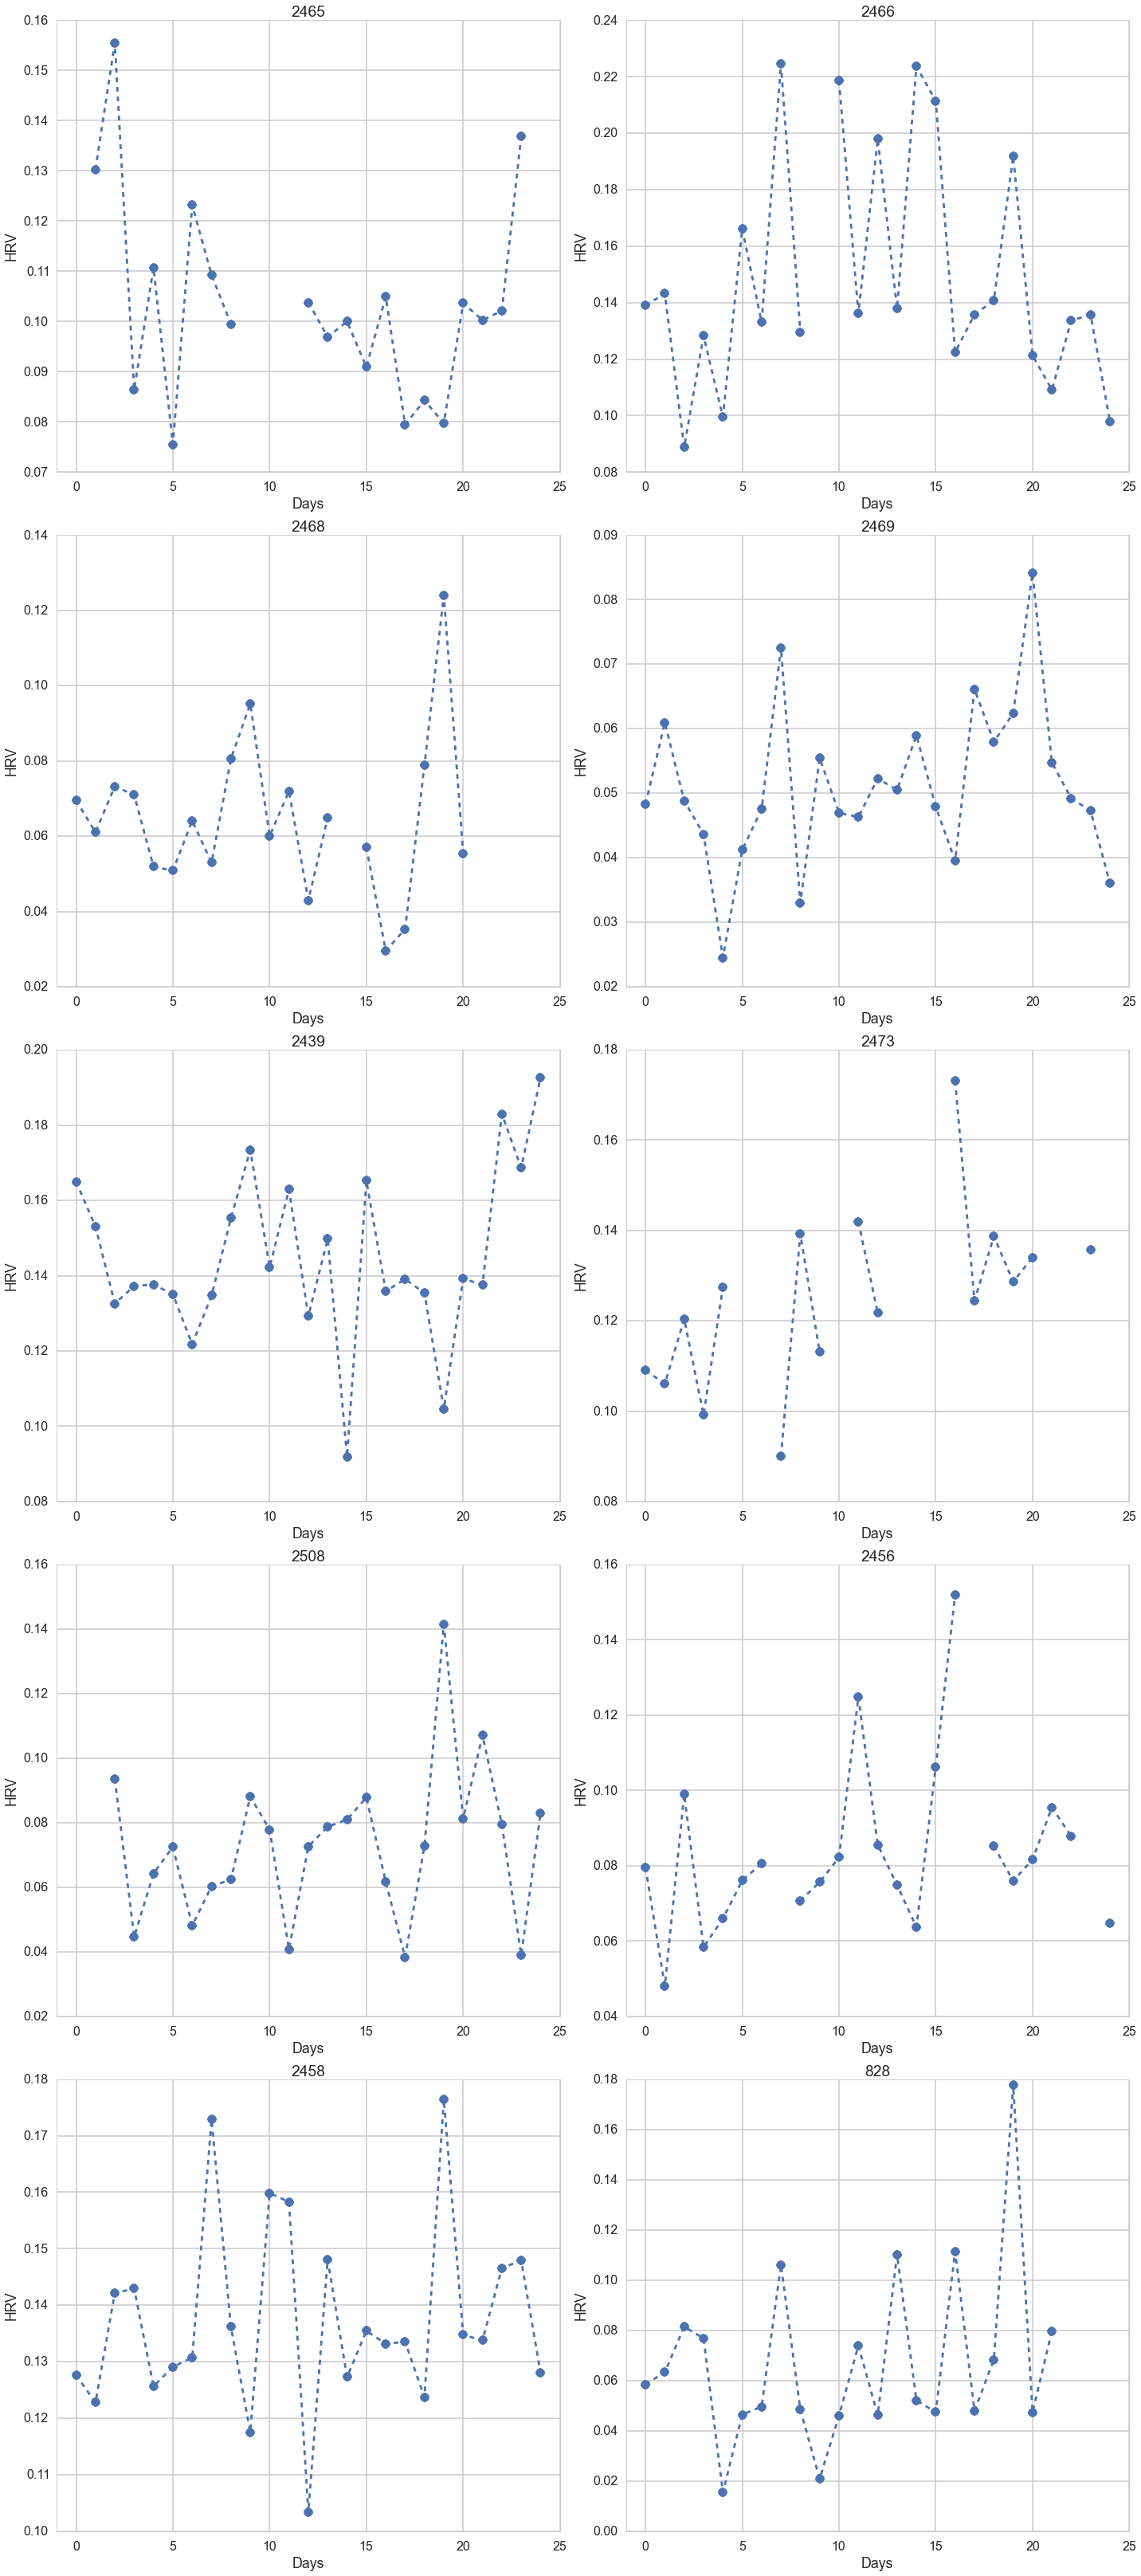

In [28]:
HRV_plots(recov_dataframe)